In [1]:
#python specific stuff
import numpy as np
import matplotlib.pyplot as plt
import time
from functions import *


In [2]:
## INITIALIZATION for time
total_time_h=3 #hours
t_step=1 #s
total_time_s=total_time_h*60*60
N_t_steps=int(total_time_s/t_step)

In [3]:
# # UPPER ROOM INITIALIZATION #########################

#SI units only =m, s, kg, C
 
#this room is where the heat is added and is the starting point of calculation (for the moment we are assuming it is the upper part
#for the surfaces, the outside edge is fixed at it's initial_T
#OUTPUT SURFACE INITIALIZATION
#use function output_surface_parameters() to define parameters

#output_surface_parameters;
#(THcond,HTC,densityC,thickness,area,N_cells,initial_T) ->see functions.py for more details

initial_T=10
ceil=output_surface_parameters(0.1,6.4,494000,0.05,500,100,initial_T)

wall_upper=output_surface_parameters(1.3,6.4,1680000,0.175,250,100,initial_T)
output_surface_array_upper=[ceil,wall_upper]

#ROOM PARAMETERS
T_room_upper=initial_T 
Qin=71874 # some constant value set by heaters
volume_room_upper=1630.43
print(volume_room_upper)
densityC_room_upper =1206
U_upper=4 # this is for conductive heat to the lower level??

# LOWER ROOM INITIALIZATION #########################

#OUTPUT SURFACE INITIALIZATION
floor=output_surface_parameters(1.3,6.4,1680000,0.175,500,100,initial_T)
wall_lower=output_surface_parameters(1.3,6.4,1680000,0.175,210,100,initial_T)
output_surface_array_lower=[wall_lower,floor]

#ROOM PARAMETERS
T_room_lower=initial_T
volume_room_lower=1369.565
densityC_room_lower =1206

1630.43


In [4]:
## DO CALCULATION ##################

data_array_T_room_upper=np.zeros(int(N_t_steps))
data_array_T_room_lower=np.zeros(int(N_t_steps))
data_array_T_wall_lower=np.zeros(int(N_t_steps))
data_array_T_wall_upper=np.zeros(int(N_t_steps))
data_array_T_ceil=np.zeros(int(N_t_steps))
data_array_T_floor=np.zeros(int(N_t_steps))

for t in range(N_t_steps):

    data_array_T_room_upper[t]=T_room_upper
    data_array_T_room_lower[t]=T_room_lower
    data_array_T_wall_lower[t]=wall_lower.T_array[0]
    data_array_T_wall_upper[t]=wall_upper.T_array[0]
    data_array_T_ceil[t]=ceil.T_array[0]
    data_array_T_floor[t]=floor.T_array[0]
    
    #treat upper room first (this is where the heat enters)
    
    Qout_room_total_upper=0
    #first deal with surfaces 
    for output_surface in output_surface_array_upper:
        #calculate Qout for room/surface boundary - CONVECTIVE
        Qout_room_to_surface=calculate_Qout_convective(output_surface.HTC,output_surface.area,T_room_upper,output_surface.T_array[0])
        Qout_room_total_upper=Qout_room_total_upper+Qout_room_to_surface  
        #calculate Qout/Qin for interior of surface
        Qout_xarray=calculate_Qout_conductive(output_surface.THcond,output_surface.area,output_surface.T_array[0:output_surface.N_cells-1],output_surface.T_array[1:output_surface.N_cells],output_surface.cell_length)
        Qin_xarray=np.append(Qout_room_to_surface,Qout_xarray[0:output_surface.N_cells-2])
        #update surface interior temperatures
        output_surface.T_array=output_surface.T_array+np.append(calculate_Tchange(Qin_xarray[0:output_surface.N_cells-1],Qout_xarray,t_step,output_surface.densityC,output_surface.volume_cell),[0]) 
    
    #now conductive to lower room
    Qout_upper_to_lower=calculate_Qout_convective(U_upper,ceil.area,T_room_upper,T_room_lower)
    Qout_room_total_upper=Qout_room_total_upper+Qout_upper_to_lower
    
    #update Temp of room using Qins and Qouts
    T_room_upper=T_room_upper+calculate_Tchange(Qin,Qout_room_total_upper,t_step,densityC_room_upper,volume_room_upper)
    
    #now do surfaces in lower room
    Qout_room_total_lower=0
    for output_surface in output_surface_array_lower:
        #calculate Qout for room/surface boundary
        Qout_room_to_surface=calculate_Qout_convective(output_surface.HTC,output_surface.area,T_room_lower,output_surface.T_array[0])
        Qout_room_total_lower=Qout_room_total_lower+Qout_room_to_surface  
        #calculate Qout/Qin for interior of surface
        Qout_xarray=calculate_Qout_conductive(output_surface.THcond,output_surface.area,output_surface.T_array[0:output_surface.N_cells-1],output_surface.T_array[1:output_surface.N_cells],output_surface.cell_length)
        Qin_xarray=np.append(Qout_room_to_surface,Qout_xarray[0:output_surface.N_cells-2])
        #update surface interior temperatures
        output_surface.T_array=output_surface.T_array+np.append(calculate_Tchange(Qin_xarray[0:output_surface.N_cells-1],Qout_xarray,t_step,output_surface.densityC,output_surface.volume_cell),[0]) 
    
    #update Temp of room using Qins and Qouts
    T_room_lower=T_room_lower+calculate_Tchange(Qout_room_total_upper,Qout_room_total_lower,t_step,densityC_room_lower,volume_room_lower)

Text(0, 0.5, 'Temperature (C)')

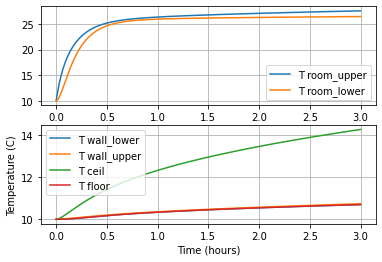

In [5]:
# MAKE PLOTS ##########################
fig, axs = plt.subplots(2)
t_array=np.arange(0,N_t_steps*t_step,t_step)/(60*60)
axs[0].plot(t_array,data_array_T_room_upper,label='T room_upper')
axs[0].plot(t_array,data_array_T_room_lower,label='T room_lower')
axs[0].legend()
axs[0].grid('True')
axs[1].plot(t_array,data_array_T_wall_lower,label='T wall_lower')
axs[1].plot(t_array,data_array_T_wall_upper,label='T wall_upper')
axs[1].plot(t_array,data_array_T_ceil,label='T ceil')
axs[1].plot(t_array,data_array_T_floor,label='T floor')
axs[1].legend()
axs[1].grid('True')
plt.xlabel('Time (hours)')
plt.ylabel('Temperature (C)')

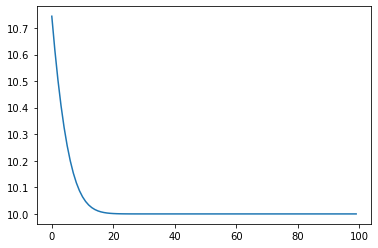

In [6]:
plt.plot(wall_upper.T_array)

0.12043585806780044
0.0017499999999999998


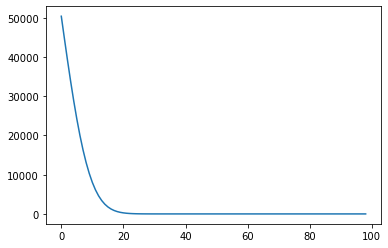

In [10]:
print(floor.T_array[0]-floor.T_array[1])
print(floor.cell_length)

plt.plot(Qin_xarray)